# A project titled "Using Autoencoder to Impute Missing Values in a Dataset" for the course ICT4362.

## The project is being supervised by, Mahir Mahbub, Lecturer, Dept. of IRE, BDU.

### Project Team:
### Sadat Hasnat Sabbir (ID: 1901002) || Md. Nur-E-Ferdous (ID: 1901033) || Tasnima Hamid (ID: 1901043)

### Importing Libraries 

In [1]:
import random
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import tensorflow as tf
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from keras.losses import mse
from keras.models import Sequential
from keras.layers import Dropout, Dense
from collections import defaultdict
from keras.regularizers import l1_l2
from keras.utils import plot_model
import pydot
import graphviz

%matplotlib inline

### Load Dataset 

In [2]:
header = ['class','capshape', 'capsurface',
'capcolor',
'bruises',
'odor',
'gillattachment',
'gillspacing',
'gillsize',
'gillcolor',
'stalkshape',
'stalkroot',
'stalksurfaceabovering',
'stalksurfacebelowring',
'stalkcolorabovering',
'stalkcolorbelowring',
'veiltype',
'veilcolor',
'ringnumber',
'ringtype',
'sporeprintcolor', 
'population',
'habitat']
df = pd.read_csv("mushroom/agaricus-lepiota.data", names=header)

In [3]:
print(df.head())

  class capshape capsurface capcolor bruises odor gillattachment gillspacing  \
0     p        x          s        n       t    p              f           c   
1     e        x          s        y       t    a              f           c   
2     e        b          s        w       t    l              f           c   
3     p        x          y        w       t    p              f           c   
4     e        x          s        g       f    n              f           w   

  gillsize gillcolor  ... stalksurfacebelowring stalkcolorabovering  \
0        n         k  ...                     s                   w   
1        b         k  ...                     s                   w   
2        b         n  ...                     s                   w   
3        n         n  ...                     s                   w   
4        b         k  ...                     s                   w   

  stalkcolorbelowring veiltype veilcolor ringnumber ringtype sporeprintcolor  \
0           

### Data Preprocessing 

#### Creating a new dataframe df_incomplete with a specified proportion of missing values, which will be used to evaluate the imputation performance of the Autoencoder. 

In [4]:
prob_missing = 0.1
df_incomplete = df.copy()
ix = [(row, col) for row in range(df.shape[0]) for col in range(df.shape[1])]
for row, col in random.sample(ix, int(round(prob_missing * len(ix)))):
    df_incomplete.iat[row, col] = np.nan

print(df_incomplete)

     class capshape capsurface capcolor bruises odor gillattachment  \
0        p        x          s        n       t    p              f   
1        e        x          s        y       t    a              f   
2        e        b          s        w       t    l              f   
3        p        x          y        w       t    p              f   
4        e        x          s        g       f    n              f   
...    ...      ...        ...      ...     ...  ...            ...   
8119     e        k          s        n       f    n              a   
8120     e        x          s        n       f    n              a   
8121     e        f          s        n       f  NaN              a   
8122   NaN        k          y        n       f    y              f   
8123     e        x          s        n       f    n              a   

     gillspacing gillsize gillcolor  ... stalksurfacebelowring  \
0              c        n         k  ...                     s   
1              

In [5]:
print(df_incomplete.isna().sum())

class                    857
capshape                 784
capsurface               805
capcolor                 799
bruises                  812
odor                     815
gillattachment           825
gillspacing              777
gillsize                 807
gillcolor                835
stalkshape               830
stalkroot                829
stalksurfaceabovering    783
stalksurfacebelowring    787
stalkcolorabovering      809
stalkcolorbelowring      785
veiltype                 861
veilcolor                854
ringnumber               804
ringtype                 827
sporeprintcolor          785
population               823
habitat                  792
dtype: int64


#### Encoding the categorical variables in the df_incomplete dataframe using one-hot encoding and also create indicator columns to represent missing values 

In [6]:
missing_encoded = pd.get_dummies(df_incomplete)
for col in df.columns:
    missing_cols = missing_encoded.columns.str.startswith(str(col) + "_")
    missing_encoded.loc[df_incomplete[col].isnull(), missing_cols]

### Reconstruction Error 

In [7]:
#Reconstruction error
def make_reconstruction_loss(n_features):
    def reconstruction_loss(input_and_mask, y_pred):
        X_values = input_and_mask[:, :n_features]
        missing_mask = input_and_mask[:, n_features:]
        observed_mask = 1 - missing_mask
        X_values_observed = X_values * observed_mask
        pred_observed = y_pred * observed_mask
        return mse(y_true=X_values_observed, y_pred=pred_observed)
    return reconstruction_loss

def masked_mae(X_true, X_pred, mask):
    masked_diff = X_true[mask] - X_pred[mask]
    return np.mean(np.abs(masked_diff))

### Building The Autoencoder 

In [8]:
#Autoencoder build
class Autoencoder:
    def __init__(self, data,
                 recurrent_weight=0.5,
                 optimizer="adam",
                 dropout_probability=0.5,
                 hidden_activation="relu",
                 output_activation="sigmoid",
                 init="glorot_normal",
                 l1_penalty=0,
                 l2_penalty=0):
        self.data = data.copy()
        self.recurrent_weight = recurrent_weight
        self.optimizer = optimizer
        self.dropout_probability = dropout_probability
        self.hidden_activation = hidden_activation
        self.output_activation = output_activation
        self.init = init
        self.l1_penalty = l1_penalty
        self.l2_penalty = l2_penalty
    def _get_hidden_layer_sizes(self):
        n_dims = self.data.shape[1]
        return [
            min(2000, 8 * n_dims),
            min(500, 2 * n_dims),
            int(np.ceil(0.5 * n_dims)),
        ]
    def _create_model(self):
        hidden_layer_sizes = self._get_hidden_layer_sizes()
        first_layer_size = hidden_layer_sizes[0]
        n_dims = self.data.shape[1]
        model = Sequential()
        model.add(Dense(
            first_layer_size,
            input_dim= 2 * n_dims,
            activation=self.hidden_activation,
            kernel_regularizer=l1_l2(self.l1_penalty, self.l2_penalty),
            kernel_initializer=self.init))
        model.add(Dropout(self.dropout_probability))
        for layer_size in hidden_layer_sizes[1:]:
            model.add(Dense(
                layer_size,
                activation=self.hidden_activation,
                kernel_regularizer=l1_l2(self.l1_penalty, self.l2_penalty),
                kernel_initializer=self.init,))
            model.add(Dropout(self.dropout_probability))
        model.add(Dense(
            n_dims,
            activation=self.output_activation,
            kernel_regularizer=l1_l2(self.l1_penalty, self.l2_penalty),
            kernel_initializer=self.init,))
        loss_function = make_reconstruction_loss(n_dims)
        model.compile(optimizer=self.optimizer, loss=loss_function)
        return model
    def fill(self, missing_mask):
        self.data[missing_mask] = -1
    def _create_missing_mask(self):
        if self.data.dtype != "f" and self.data.dtype != "d":
            self.data = self.data.astype(float)
        return np.isnan(self.data)
    def _train_epoch(self, model, missing_mask, batch_size):
        input_with_mask = np.hstack([self.data, missing_mask])
        n_samples = len(input_with_mask)
        n_batches = int(np.ceil(n_samples / batch_size))
        indices = np.arange(n_samples)
        np.random.shuffle(indices)
        X_shuffled = input_with_mask[indices]
        for batch_idx in range(n_batches):
            batch_start = batch_idx * batch_size
            batch_end = (batch_idx + 1) * batch_size
            batch_data = X_shuffled[batch_start:batch_end, :]
            model.train_on_batch(batch_data, batch_data)
        return model.predict(input_with_mask)
    def train(self, batch_size=256, train_epochs=100):
        missing_mask = self._create_missing_mask()
        self.fill(missing_mask)
        self.model = self._create_model()
        observed_mask = ~missing_mask
        observed_maes = []
        for epoch in range(train_epochs):
            X_pred = self._train_epoch(self.model, missing_mask, batch_size)
            if epoch == 0:
                self.model.summary()
            observed_mae = masked_mae(X_true=self.data,
                                    X_pred=X_pred,
                                    mask=observed_mask)
            print("observed mae:", observed_mae)
            observed_maes.append(observed_mae)
            old_weight = (1.0 - self.recurrent_weight)
            self.data[missing_mask] *= old_weight
            pred_missing = X_pred[missing_mask]
            self.data[missing_mask] += self.recurrent_weight * pred_missing
        return self.data.copy(), observed_maes

### Training the Autoenoder 

254/254 [==============================] - 1s 2ms/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 952)               227528    
                                                                 
 dropout (Dropout)           (None, 952)               0         
                                                                 
 dense_1 (Dense)             (None, 238)               226814    
                                                                 
 dropout_1 (Dropout)         (None, 238)               0         
                                                                 
 dense_2 (Dense)             (None, 60)                14340     
                                                                 
 dropout_2 (Dropout)         (None, 60)                0         
                                                                 
 

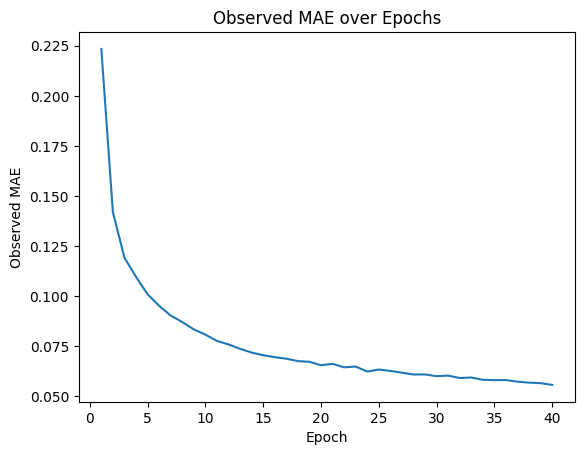

In [9]:
imputer = Autoencoder(missing_encoded.values)
complete_encoded, observed_maes = imputer.train(train_epochs=40, batch_size=256)

import matplotlib.pyplot as plt

plt.plot(range(1, len(observed_maes) + 1), observed_maes)
plt.xlabel('Epoch')
plt.ylabel('Observed MAE')
plt.title('Observed MAE over Epochs')
plt.show()

In [10]:
complete_encoded[10, :10]

array([1., 0., 0., 0., 0., 0., 0., 1., 0., 0.])

In [11]:
def mle(row):
    res = np.zeros(row.shape[0])
    res[np.argmax(row)] = 1
    return res
col_classes = [len(df[c].unique()) for c in df.columns]
dummy_df = pd.get_dummies(df)
mle_complete = None
for i, cnt in enumerate(col_classes):
    start_idx = int(sum(col_classes[0:i]))
    col_true = dummy_df.values[:, start_idx:start_idx+cnt]
    col_completed = complete_encoded[:, start_idx:start_idx+cnt]
    mle_completed = np.apply_along_axis(mle, axis=1, arr=col_completed)
    if mle_complete is None:
        mle_complete = mle_completed
    else:
        mle_complete = np.hstack([mle_complete, mle_completed])

In [12]:
mle_complete[10, :10]

array([1., 0., 0., 0., 0., 0., 0., 1., 0., 0.])

### Imputing Missing Values 

In [13]:
def reverse_dummy(df_dummies):
    pos = defaultdict(list)
    vals = defaultdict(list)
    for i, c in enumerate(df_dummies.columns):
        if "_" in c:
            k, v = c.split("_", 1)
            pos[k].append(i)
            vals[k].append(v)
        else:
            pos["_"].append(i)
    df = pd.DataFrame({k: pd.Categorical.from_codes(
                              np.argmax(df_dummies.iloc[:, pos[k]].values, axis=1),
                              vals[k])
                      for k in vals})
    df[df_dummies.columns[pos["_"]]] = df_dummies.iloc[:, pos["_"]]
    return df
rev_df = reverse_dummy(pd.DataFrame(data=mle_complete, columns=dummy_df.columns))
rev_df = rev_df[list(df.columns)]
rev_df.to_csv("imputed_data.csv")

In [14]:
print(rev_df.head())

  class capshape capsurface capcolor bruises odor gillattachment gillspacing  \
0     p        x          s        n       t    p              f           c   
1     e        x          s        y       t    a              f           c   
2     e        b          s        w       t    l              f           c   
3     p        x          y        w       t    p              f           c   
4     e        x          s        g       f    n              f           w   

  gillsize gillcolor  ... stalksurfacebelowring stalkcolorabovering  \
0        n         k  ...                     s                   w   
1        b         k  ...                     s                   w   
2        b         n  ...                     s                   w   
3        n         n  ...                     s                   w   
4        b         k  ...                     s                   w   

  stalkcolorbelowring veiltype veilcolor ringnumber ringtype sporeprintcolor  \
0           

In [15]:
print(rev_df.isna().sum())

class                    0
capshape                 0
capsurface               0
capcolor                 0
bruises                  0
odor                     0
gillattachment           0
gillspacing              0
gillsize                 0
gillcolor                0
stalkshape               0
stalkroot                0
stalksurfaceabovering    0
stalksurfacebelowring    0
stalkcolorabovering      0
stalkcolorbelowring      0
veiltype                 0
veilcolor                0
ringnumber               0
ringtype                 0
sporeprintcolor          0
population               0
habitat                  0
dtype: int64


### Accuracy 

In [16]:
# Create a mask indicating the observed (non-missing) values in the original data
observed_mask = ~np.isnan(missing_encoded.values)

# Calculate the imputation performance (MAE) using the masked_mae function
imputation_performance = masked_mae(X_true=missing_encoded.values,
                                    X_pred=mle_complete,
                                    mask=observed_mask)

# Print the imputation performance
print("Imputation performance (MAE):", imputation_performance*100)

Imputation performance (MAE): 1.932752421500358


In [17]:
from sklearn.metrics import accuracy_score

# Convert the predicted values to class labels
imputed_labels = np.argmax(mle_complete, axis=1)

# Convert the true values to class labels
true_labels = np.argmax(missing_encoded.values, axis=1)

# Calculate classification accuracy
accuracy = accuracy_score(true_labels, imputed_labels)

# Print the classification accuracy
print("Accuracy:", accuracy*100)


Accuracy: 89.45100935499754
